In [ ]:
# 파일이름 : MES_CMB_data_generator.ipynb
# 코드설명 : 고무 배합비와 제조실행시스템(MES)에서 얻어진 검사 CMB 데이터에 대한 전처리 및 모델 학습 데이터 세트 생성
# 입/출력 : MES 통합 데이터 (DA측 제공) / MES CMB 데이터 세트(17개)
# 유의 사항 : 물성값이 0인 경우 제외
# 최종수정 : 2023년 11월 23일
# 제 작 자 : 홍민성 (mshong@micube.co.kr), 맹영준 (myj6223@micube.co.kr)
# Copyright : MICUBE Solution, Inc.

In [11]:
import pandas as pd
import numpy as np

pd.set_option("display.max_columns", 500)
pd.set_option('display.max_rows', 50)

import seaborn as sns
sns.set(rc={'figure.figsize':(15, 5)})
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore')

## 1. 데이터 로드 및 분류, 이상치 조정

### 1) 데이터 로드 및 분류, 점검

In [12]:
mes_full_df=pd.read_csv('../dataset/sfites_real_mix_data_full.csv')

#### CMB와 FMB 데이터 분리

In [13]:
# CMB와 FMB 데이터 분리
mes_c1_df = mes_full_df[mes_full_df['RUBBER'].str[-2:]=='C1']
mes_f1_df = mes_full_df[mes_full_df['RUBBER'].str[-2:]!='C1']

#### FMB의 데이터의 통계 분석

In [15]:
# FMB 데이터 중,순수 FMB와 CMB의 연속 배합인 경우를 구분 
# (첫번째 원자재코드가 C1을 포함하는지 여부 체크)
mes_f1_c1_df = mes_f1_df[mes_f1_df['1_JRCODE'].str[-2:]=='C1']
mes_f1_noC1_df = mes_f1_df[mes_f1_df['1_JRCODE'].str[-2:]!='C1']

# 원본 데이터프레임(df)에서 "RUBBER" 값이 c1_filtered_df의 "" 값과 일치하는 행만 선택
matching_df = mes_full_df[mes_full_df['RUBBER'].isin(mes_f1_c1_df['1_JRCODE'].unique())]

# RUBBER 그룹별 개수 체크
group_counts = matching_df['RUBBER'].value_counts()

# 10개 미만인 데이터를 가진 그룹만 필터링
trg_mes_f1_remove_jrcode_ls = group_counts[group_counts < 10].index
trg_mes_f1_remove_df = mes_f1_c1_df[mes_f1_c1_df['1_JRCODE'].isin(trg_mes_f1_remove_jrcode_ls)]

# 10개 이상의 데이터를 가진 그룹만 필터링
trg_mes_f1_c1_jrcode_ls = group_counts[group_counts >= 10].index
trg_mes_f1_c1_df = mes_f1_c1_df[mes_f1_c1_df['1_JRCODE'].isin(trg_mes_f1_c1_jrcode_ls)]

# 앞에 있는 C1이 데이터상에 없는 그룹만 필터링
trg_mes_f1_wo_c1_df = mes_f1_c1_df[~(mes_f1_c1_df['1_JRCODE'].isin(group_counts.index))]

print(f"1. 총 데이터 수 : {len(mes_full_df):,}")
print(f"2. f1 데이터 수 : {len(mes_f1_df):,} // 3. C1 데이터 수 : {len(mes_c1_df):,} // 2+3. 합 : {(len(mes_f1_df) + len(mes_c1_df)):,}")
print(f"4. f1 중 C1이 필요한 데이터 수 : {len(mes_f1_c1_df):,} // 5. f1 중 C1이 필요없는 데이터 수 : {len(mes_f1_noC1_df):,} // 4/5. 합 : {(len(mes_f1_c1_df) + len(mes_f1_noC1_df)):,}")
print(f"6. f1 중 C1이 필요한 데이터에서 C1이 10개 미만인 데이터의 수 : {len(trg_mes_f1_remove_df):,}")
print(f"7. f1 중 C1이 필요한 데이터에서 매칭되는 C1이 없는 데이터의 수 : {len(trg_mes_f1_wo_c1_df):,}")
print(f"8. f1 중 C1이 필요한 데이터에서 C1이 10개 이상인 데이터의 수 : {len(trg_mes_f1_c1_df):,}")
print(f"4. f1 중 C1이 필요한 데이터 수 : {len(mes_f1_c1_df):,} // 6+7+8. 합 수 : {(len(trg_mes_f1_remove_df)+len(trg_mes_f1_c1_df)+len(trg_mes_f1_wo_c1_df)):,}")

1. 총 데이터 수 : 516,690
2. f1 데이터 수 : 262,765 // 3. C1 데이터 수 : 253,925 // 2+3. 합 : 516,690
4. f1 중 C1이 필요한 데이터 수 : 259,310 // 5. f1 중 C1이 필요없는 데이터 수 : 3,455 // 4/5. 합 : 262,765
6. f1 중 C1이 필요한 데이터에서 C1이 10개 미만인 데이터의 수 : 4,016
7. f1 중 C1이 필요한 데이터에서 매칭되는 C1이 없는 데이터의 수 : 22,393
8. f1 중 C1이 필요한 데이터에서 C1이 10개 이상인 데이터의 수 : 232,901
4. f1 중 C1이 필요한 데이터 수 : 259,310 // 6+7+8. 합 수 : 259,310


#### C1의 연속인 FMB 데이터의 통계 분석 및 이상 FMB 데이터 제거

In [16]:
tmp_df = mes_c1_df[mes_c1_df['1_JRCODE'].str[-2:]=='C1']
pd.concat((tmp_df.iloc[:,:5],tmp_df.iloc[:,100:]),axis=1)
print(f"C1 데이터 수 : {len(mes_c1_df):,}")
print(f"C1 데이터 중 1_JRCODE가 자기 자신인 데이터 수 : {(tmp_df['RUBBER']==tmp_df['1_JRCODE']).sum()}")
print(f"C1 데이터 중 1_JRCODE가 자기 자신이 아닌 데이터 수 : {(tmp_df['RUBBER']!=tmp_df['1_JRCODE']).sum()}")
print(f"C1 데이터 중 1_JRCODE가 자기 자신이 아닌 데이터의 1_JRCODE 변수의 RUBBER ID들 : {tmp_df[(tmp_df['RUBBER']!=tmp_df['1_JRCODE'])]['1_JRCODE'].unique()}")

# C1중 1_JRCODE가 자기 자신 또는 원재료코드가 아닌 경우 제외
mes_c1_df = mes_c1_df[mes_c1_df['1_JRCODE'].str[-2:]!='C1']
mes_c1_df.reset_index(drop=True, inplace=True)

C1 데이터 수 : 253,925
C1 데이터 중 1_JRCODE가 자기 자신인 데이터 수 : 222
C1 데이터 중 1_JRCODE가 자기 자신이 아닌 데이터 수 : 63
C1 데이터 중 1_JRCODE가 자기 자신이 아닌 데이터의 1_JRCODE 변수의 RUBBER ID들 : ['4450-Y1.00-C1' '2000-R1.00-C1']


### 2) phr 상대적 값으로 조정

In [17]:
phr_cols = ['1_PHR','2_PHR','3_PHR','4_PHR','5_PHR','6_PHR','7_PHR','8_PHR','9_PHR','10_PHR','11_PHR','12_PHR','13_PHR','14_PHR','15_PHR','16_PHR','17_PHR','18_PHR','19_PHR','20_PHR','21_PHR']
mes_c1_df[phr_cols] = mes_c1_df[phr_cols].apply(lambda x: x / x.max() * 100, axis=1)
mes_c1_df.head()

,LOTNO,RUBBER,MECHCD,RPM1,RPM2,RPM3,RPM4,RPM5,RPM6,RPM7,RPM8,RPM9,RPM10,RPM11,RPM12,RPM13,RPM14,RPM15,RPM16,RPM17,RPM18,RPM19,RPM20,TEMP1,TEMP2,TEMP3,TEMP4,TEMP5,TEMP6,TEMP7,TEMP8,TEMP9,TEMP10,TEMP11,TEMP12,TEMP13,TEMP14,TEMP15,TEMP16,TEMP17,TEMP18,TEMP19,TEMP20,TIME1,TIME2,TIME3,TIME4,TIME5,TIME6,TIME7,TIME8,TIME9,TIME10,TIME11,TIME12,TIME13,TIME14,TIME15,TIME16,TIME17,TIME18,TIME19,TIME20,JUK1,JUK2,JUK3,JUK4,JUK5,JUK6,JUK7,JUK8,JUK9,JUK10,JUK11,JUK12,JUK13,JUK14,JUK15,JUK16,JUK17,JUK18,JUK19,JUK20,HS,HS_RESULT,SG,SG_RESULT,TS,TS_RESULT,EB,EB_RESULT,MNY,MNY_RESULT,REHO_MIN,REHO_MAX,REHO_TS2,REHO_TC90,REHO_RESULT,SCR,SCR_RESULT,1_JRCODE,2_JRCODE,3_JRCODE,4_JRCODE,5_JRCODE,6_JRCODE,7_JRCODE,8_JRCODE,9_JRCODE,10_JRCODE,11_JRCODE,12_JRCODE,13_JRCODE,14_JRCODE,15_JRCODE,16_JRCODE,17_JRCODE,18_JRCODE,19_JRCODE,20_JRCODE,21_JRCODE,1_PHR,2_PHR,3_PHR,4_PHR,5_PHR,6_PHR,7_PHR,8_PHR,9_PHR,10_PHR,11_PHR,12_PHR,13_PHR,14_PHR,15_PHR,16_PHR,17_PHR,18_PHR,19_PHR,20_PHR,21_PHR,1_PUTGB,2_PUTGB,3_PUTGB,4_PUTGB,5_PUTGB,6_PUTGB,7_PUTGB,8_PUTGB,9_PUTGB,10_PUTGB,11_PUTGB,12_PUTGB,13_PUTGB,14_PUTGB,15_PUTGB,16_PUTGB,17_PUTGB,18_PUTGB,19_PUTGB,20_PUTGB,21_PUTGB,1_PUTORDER,2_PUTORDER,3_PUTORDER,4_PUTORDER,5_PUTORDER,6_PUTORDER,7_PUTORDER,8_PUTORDER,9_PUTORDER,10_PUTORDER,11_PUTORDER,12_PUTORDER,13_PUTORDER,14_PUTORDER,15_PUTORDER,16_PUTORDER,17_PUTORDER,18_PUTORDER,19_PUTORDER,20_PUTORDER,21_PUTORDER,HS_TIME,SG_TIME,TS_TIME,EB_TIME,HS_TEMP,SG_TEMP,TS_TEMP,EB_TEMP,MNY_TIME,MNY_TEMP,REHO_TIME,REHO_TEMP,SCR_TIME,SCR_TEMP
0,G0116I130012001,1572-N2.02-C1,B-1-01,1195.0,1204.0,1203.0,1204.0,1204.0,1204.0,1204.0,1210.0,1204.0,1203.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,43.4,60.8,75.3,69.7,107.9,106.3,129.8,136.7,165.3,157.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,23.3,24.5,23.7,34.4,18.3,24.4,6.5,27.9,16.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,434.0,28.0,43.0,86.0,11.0,62.0,34.0,8.0,71.0,57.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EE017,EE011,CB001,CB011,CC001,CC012,CD013,CD023,CB003,FF001,NN045,OP004,NN045,OP004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.000000,28.698980,0.956633,0.956633,0.478316,0.956633,1.441327,0.478316,4.719388,26.530612,44.515306,24.196429,22.066327,11.696429,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,3.0,4.0,3.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,G0116H310001002,1703-T2.01-C1,B-1-01,1011.0,1020.0,1021.0,1021.0,1020.0,1020.0,1021.0,1022.0,1017.0,1027.0,1021.0,1020.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,151.1,74.6,69.8,80.9,76.3,68.8,87.5,89.3,139.4,143.5,174.1,165.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.7,22.4,10.4,34.4,26.7,30.7,24.5,8.0,48.3,7.0,36.3,16.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.0,36.0,4.0,80.0,131.0,132.0,80.0,48.0,107.0,26.0,78.0,60.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EE017,CB001,CC001,CC012,CB003,FF001,NN550,NN550,OP008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.000000,0.663265,1.326531,0.994898,3.954082,36.224490,47.831633,66.326531,39.706633,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,2.0,2.0,3.0,3.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,G0116H310012001,1700-H1.01-C1,B-1-01,1203.0,1205.0,1204.0,1204.0,1204.0,1206.0,1206.0,1019.0,1026.0,920.0,920.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,52.2,56.1,57.6,54.1,53.5,79.5,82.7,108.5,114.1,168.8,157.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.8,13.9,39.6,16.1,24.8,19.7,8.6,24.4,6.5,56.8,16.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,648.0,15.0,87.0,45.0,44.0,47.0,11.0,56.0,11.0,160.0,59.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EE011,EE002,CB001,CB011,CD013,CC0

## 2. 최종 MES CMB 데이터 세트 생성 및 저장
- 물성값 : 기본물성(4개)과 가류/점도(6개)
- 불량여부 : 기본물성(4개)과 가류/점도(3개)

In [18]:
basic_cols = ['LOTNO','RUBBER']
# 변수명 조정 필요
# ========================================================
rpm_cols = ['RPM1','RPM2','RPM3','RPM4','RPM5','RPM6','RPM7','RPM8','RPM9','RPM10','RPM11','RPM12','RPM13','RPM14','RPM15','RPM16','RPM17','RPM18','RPM19','RPM20']
temp_cols = ['TEMP1','TEMP2','TEMP3','TEMP4','TEMP5','TEMP6','TEMP7','TEMP8','TEMP9','TEMP10','TEMP11','TEMP12','TEMP13','TEMP14','TEMP15','TEMP16','TEMP17','TEMP18','TEMP19','TEMP20']
time_cols = ['TIME1','TIME2','TIME3','TIME4','TIME5','TIME6','TIME7','TIME8','TIME9','TIME10','TIME11','TIME12','TIME13','TIME14','TIME15','TIME16','TIME17','TIME18','TIME19','TIME20']
juk_cols = ['JUK1','JUK2','JUK3','JUK4','JUK5','JUK6','JUK7','JUK8','JUK9','JUK10','JUK11','JUK12','JUK13','JUK14','JUK15','JUK16','JUK17','JUK18','JUK19','JUK20']
jrcode_cols = ['1_JRCODE','2_JRCODE','3_JRCODE','4_JRCODE','5_JRCODE','6_JRCODE','7_JRCODE','8_JRCODE','9_JRCODE','10_JRCODE','11_JRCODE','12_JRCODE','13_JRCODE','14_JRCODE','15_JRCODE','16_JRCODE','17_JRCODE','18_JRCODE','19_JRCODE','20_JRCODE','21_JRCODE']
phr_cols = ['1_PHR','2_PHR','3_PHR','4_PHR','5_PHR','6_PHR','7_PHR','8_PHR','9_PHR','10_PHR','11_PHR','12_PHR','13_PHR','14_PHR','15_PHR','16_PHR','17_PHR','18_PHR','19_PHR','20_PHR','21_PHR']
putgb_cols = ['1_PUTGB','2_PUTGB','3_PUTGB','4_PUTGB','5_PUTGB','6_PUTGB','7_PUTGB','8_PUTGB','9_PUTGB','10_PUTGB','11_PUTGB','12_PUTGB','13_PUTGB','14_PUTGB','15_PUTGB','16_PUTGB','17_PUTGB','18_PUTGB','19_PUTGB','20_PUTGB','21_PUTGB']
# 변수명 조정 필요
# ========================================================

trg_ispt_cols = ['HS_TIME','SG_TIME','TS_TIME','EB_TIME','MNY_TIME','REHO_TIME','SCR_TIME','HS_TEMP','SG_TEMP','TS_TEMP','EB_TEMP','MNY_TEMP','REHO_TEMP','SCR_TEMP']
trg_regression_cols = ['HS','SG','TS','EB','MNY','REHO_MIN','REHO_MAX','REHO_TS2','REHO_TC90','SCR']
trg_classification_cols = ['HS_RESULT','SG_RESULT','TS_RESULT','EB_RESULT','MNY_RESULT','REHO_RESULT','SCR_RESULT']

data_df = mes_c1_df.copy()
# 무늬와 스코치 검사 시간 데이터 고침
data_df['MNY_TIME'] = np.where((data_df['MNY_TIME']=='1+4'), 5, data_df['MNY_TIME'])
data_df['SCR_TIME'] = np.where((data_df['SCR_TIME']=='1+4'), 5, data_df['SCR_TIME'])
data_df['MNY_TIME'] = data_df['MNY_TIME'].astype('float')
data_df['SCR_TIME'] = data_df['SCR_TIME'].astype('float')

for yCol in trg_regression_cols:
    tmp_ispt_cols = [col for col in trg_ispt_cols if yCol[:2] in col]
    fin_df = data_df[basic_cols+rpm_cols+temp_cols+time_cols+juk_cols+jrcode_cols+phr_cols+putgb_cols+tmp_ispt_cols+[yCol]]
    # nan값과 0값 제거
    fin_df = fin_df[~(fin_df[yCol].isna())&(fin_df[yCol]!=0)]
    print(f"For {yCol} data # : {len(fin_df)} nan # for {yCol} : {fin_df[yCol].isna().sum()}")

    fin_df.to_csv(f'./tmp_dataset/mes_regr_cmb_data_{yCol}_fin_noZero.csv', index=False)

for yCol in trg_classification_cols:
    tmp_ispt_cols = [col for col in trg_ispt_cols if yCol[:2] in col]
    fin_df = data_df[basic_cols+rpm_cols+temp_cols+time_cols+juk_cols+jrcode_cols+phr_cols+putgb_cols+tmp_ispt_cols+[yCol]]
    # nan값 제거
    fin_df = fin_df[~(fin_df[yCol].isna())]
    # 불량여부에 대한 1/0값 변경
    fin_df[yCol] = [1 if col=='P' else 0 for col in fin_df[yCol]]
    print(f"For {yCol} data # : {len(fin_df)} nan # for {yCol} : {fin_df[yCol].isna().sum()}")

    fin_df.to_csv(f'./tmp_dataset/mes_clas_cmb_data_{yCol}_fin.csv', index=False)

For HS data # : 10144 nan # for HS : 0
For SG data # : 41072 nan # for SG : 0
For TS data # : 9851 nan # for TS : 0
For EB data # : 9852 nan # for EB : 0
For MNY data # : 58817 nan # for MNY : 0
For REHO_MIN data # : 11236 nan # for REHO_MIN : 0
For REHO_MAX data # : 11251 nan # for REHO_MAX : 0
For REHO_TS2 data # : 11225 nan # for REHO_TS2 : 0
For REHO_TC90 data # : 11228 nan # for REHO_TC90 : 0
For SCR data # : 10786 nan # for SCR : 0
For HS_RESULT data # : 10001 nan # for HS_RESULT : 0
For SG_RESULT data # : 51708 nan # for SG_RESULT : 0
For TS_RESULT data # : 9538 nan # for TS_RESULT : 0
For EB_RESULT data # : 9538 nan # for EB_RESULT : 0
For MNY_RESULT data # : 59851 nan # for MNY_RESULT : 0
For REHO_RESULT data # : 11493 nan # for REHO_RESULT : 0
For SCR_RESULT data # : 11067 nan # for SCR_RESULT : 0


## 3. 데이터 점검

### 물성별 Nan과 0값이 아닌 데이터의 수 체크

In [19]:
trg_regression_cols = ['HS','SG','TS','EB','MNY','REHO_MIN','REHO_MAX','REHO_TS2','REHO_TC90','SCR']
trg_classification_cols = ['HS_RESULT','SG_RESULT','TS_RESULT','EB_RESULT','MNY_RESULT','REHO_RESULT','SCR_RESULT']
trg_cols = trg_regression_cols + trg_classification_cols
for yCol in trg_cols:
    print(yCol, len(mes_full_df[~(mes_full_df[yCol].isna())&(mes_full_df[yCol]!=0)]))

HS 34117
SG 62123
TS 31664
EB 31666
MNY 59333
REHO_MIN 219481
REHO_MAX 219479
REHO_TS2 219447
REHO_TC90 219449
SCR 53341
HS_RESULT 33849
SG_RESULT 72798
TS_RESULT 30415
EB_RESULT 30415
MNY_RESULT 60419
REHO_RESULT 220899
SCR_RESULT 58680


### 물성별 분포 시각화

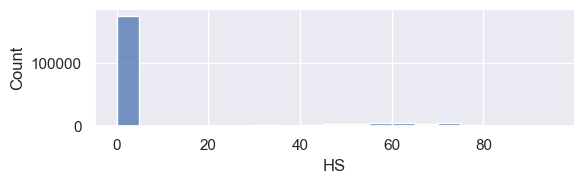

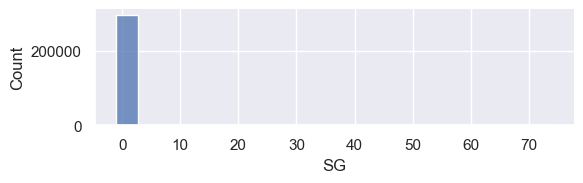

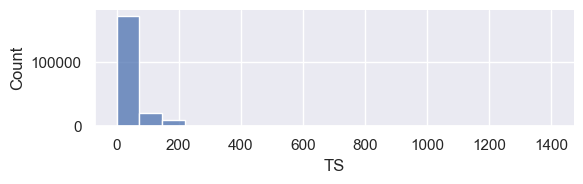

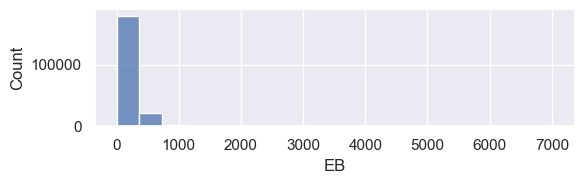

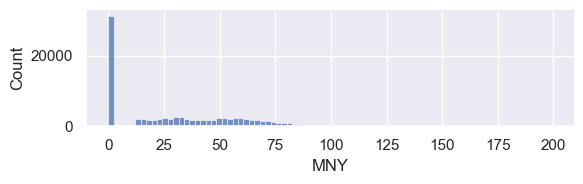

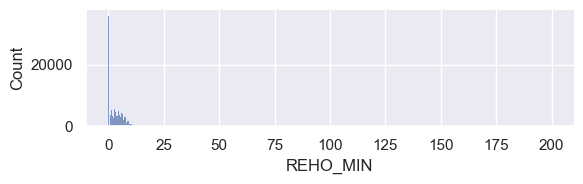

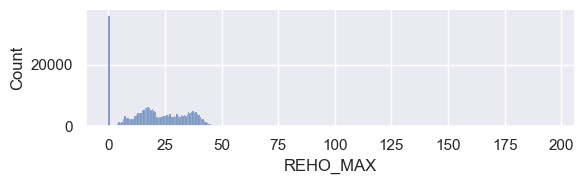

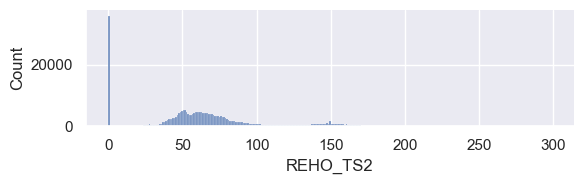

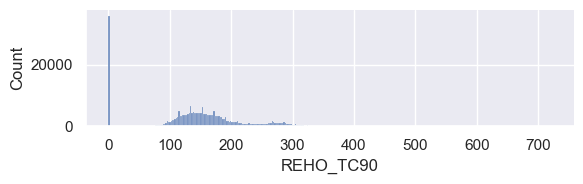

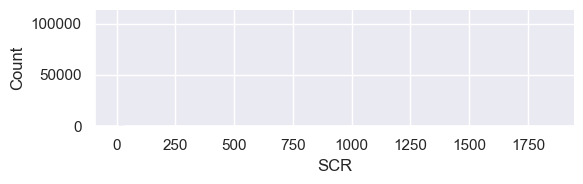

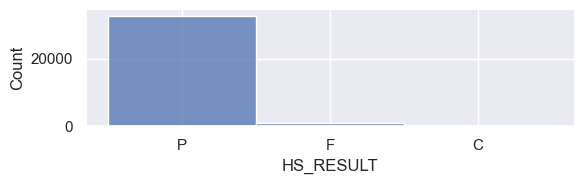

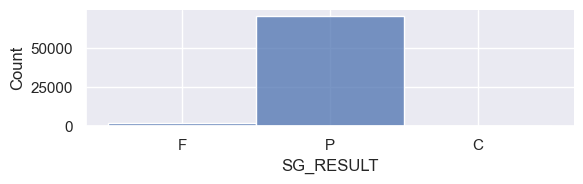

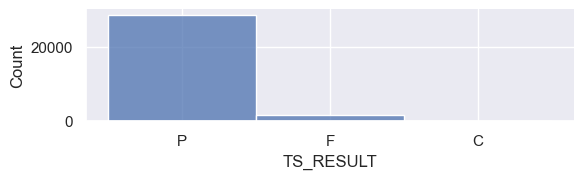

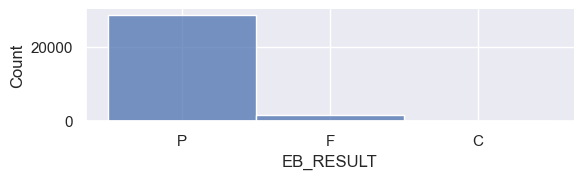

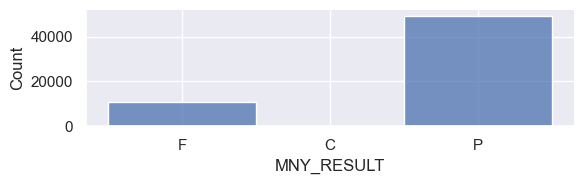

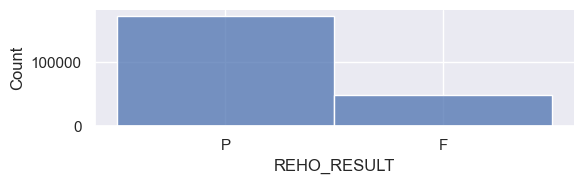

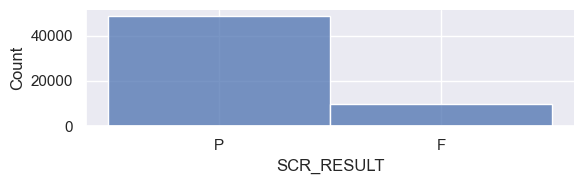

In [20]:
trg_regression_cols = ['HS','SG','TS','EB','MNY','REHO_MIN','REHO_MAX','REHO_TS2','REHO_TC90','SCR']
trg_classification_cols = ['HS_RESULT','SG_RESULT','TS_RESULT','EB_RESULT','MNY_RESULT','REHO_RESULT','SCR_RESULT']
trg_cols = trg_regression_cols + trg_classification_cols
for yCol in trg_cols:
    sns.displot(mes_full_df[yCol], height=2, aspect=3)